# Deep Learning Project

### Module installation for Google colab

In [20]:
!pip3 install --no-cache-dir -I pillow
!pip install --no-cache-dir -I pillow
!pip freeze

    100% |████████████████████████████████| 2.0MB 32.1MB/s 


In [5]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [6]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip3 install torchtext
!pip3 install torchvision

In [2]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    
    #os.unlink(zip_path)

### Check data upload

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

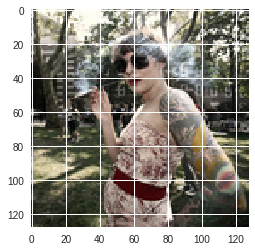

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('train/images/im1.jpg')

plt.imshow(img);

### Function to plot the image form a input tensor

In [0]:
def plot_image(tensor):

  x = tensor.permute(1,2,0).data.numpy()

  plt.imshow(x);

### Function to create the csv for associate to the image the labels contain in the folder "annotation"

In [32]:
from os.path import isfile, join
import pandas as pd
import numpy as np


file_col=listdir("train/images")
list1 = [int(x[2:len(x)-4]) for x in file_col]
list1.sort()
listfin=["train/images/im"+str(num)+".jpg" for num in list1]

file_col=pd.Series(listfin)

df=pd.DataFrame()
df["fileName"]=file_col

path = "train/annotations"

row = 0

dic = {}

for label, filename in enumerate(listdir(path)):
  tmp=np.zeros(file_col.shape[0])
  with open(path+"/"+filename, "r") as file:
    file_len = 0
    for line in file:
      line = line.replace("\n", "")
      line = int(line)
      tmp[line-1] = 1
      file_len = file_len + 1
  tmp=pd.Series(tmp)
  df[filename]=tmp
  dic[filename] = file_len

print(dic)


{'bird.txt': 360, 'baby.txt': 95, 'flower.txt': 761, 'clouds.txt': 1095, 'sea.txt': 173, 'male.txt': 2979, 'female.txt': 3227, 'river.txt': 120, 'people.txt': 6403, 'car.txt': 319, 'portrait.txt': 3121, 'dog.txt': 448, 'tree.txt': 525, 'night.txt': 598}


In [34]:
df.head()

,fileName,bird.txt,baby.txt,flower.txt,clouds.txt,sea.txt,male.txt,female.txt,river.txt,people.txt,car.txt,portrait.txt,dog.txt,tree.txt,night.txt
0,train/images/im1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,train/images/im2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train/images/im3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train/images/im4.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,train/images/im5.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df.loc[19998]

fileName        train/images/im19999.jpg
bird.txt                               0
baby.txt                               0
flower.txt                             0
clouds.txt                             0
sea.txt                                0
male.txt                               0
female.txt                             1
river.txt                              0
people.txt                             1
car.txt                                0
portrait.txt                           1
dog.txt                                0
tree.txt                               0
night.txt                              0
Name: 19998, dtype: object

### Given the csv that maps file and labels, create the pytorch data loader

In [0]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import operator

class ImageDataLoader(Dataset):
  def __init__(self,dataframe, dic):
    
    self.to_tensor = transforms.ToTensor()
    
    self.data_info = dataframe
    
    # First col is the path of the image
    self.image_arr = np.asarray(self.data_info.iloc[:,0])
    
    # Other cols are labels
    self.label_arr = np.asarray(self.data_info.iloc[:,range(1,self.data_info.shape[1])])
    
    # Len
    self.data_len = len(self.data_info.index)
    
    # dictionary with all the files (ordered) by value from lowest to highest
    self.file_dic = sorted(dic.items(), key=lambda kv: kv[1])
    
    # print(self.file_dic)
  
  def __getitem__(self, index):
    
    # Get image name from the pandas df
    single_image_name = self.image_arr[index]
    
    # Open image
    img_as_img = Image.open(single_image_name)
    
    # Transform image to tensor
    img_as_tensor = self.to_tensor(img_as_img)

    # Get label(class) of the image based on the cropped pandas column
    single_image_label = self.label_arr[index]

    return (img_as_tensor, single_image_label)
  
  def len(self):
    return self.data_len
  
    
    

In [0]:
data_loader=ImageDataLoader(df, file_dic)

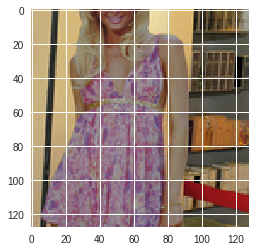

In [0]:
#to plot the immage
plot_image(data_loader.__getitem__(19998)[0])

In [0]:
#to get the tensor associated to the immage
data_loader.__getitem__(19998)[0]

tensor([[[0.7725, 0.7725, 0.7765,  ..., 0.5961, 0.6078, 0.6157],
         [0.7725, 0.7725, 0.7765,  ..., 0.6314, 0.6314, 0.6314],
         [0.7725, 0.7725, 0.7765,  ..., 0.6431, 0.6314, 0.6392],
         ...,
         [0.6667, 0.7059, 0.6706,  ..., 0.3961, 0.4000, 0.4157],
         [0.6863, 0.6784, 0.6863,  ..., 0.4000, 0.4157, 0.4235],
         [0.6784, 0.6941, 0.6745,  ..., 0.3804, 0.3804, 0.3765]],

        [[0.6824, 0.6824, 0.6863,  ..., 0.5922, 0.5961, 0.6000],
         [0.6784, 0.6784, 0.6824,  ..., 0.6275, 0.6157, 0.6157],
         [0.6784, 0.6784, 0.6824,  ..., 0.6353, 0.6235, 0.6314],
         ...,
         [0.6078, 0.6118, 0.5961,  ..., 0.3529, 0.3490, 0.3529],
         [0.6078, 0.6078, 0.6078,  ..., 0.3647, 0.3725, 0.3804],
         [0.6000, 0.6000, 0.6196,  ..., 0.3529, 0.3569, 0.3529]],

        [[0.4784, 0.4863, 0.4902,  ..., 0.5216, 0.5373, 0.5529],
         [0.4902, 0.4902, 0.4941,  ..., 0.5569, 0.5686, 0.5686],
         [0.4980, 0.4980, 0.5020,  ..., 0.5765, 0.5765, 0.

In [0]:
#to get the lable asscoated to the image
data_loader.__getitem__(19998)[1]